In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import CLIPTokenizer, CLIPTextModel

In [ ]:
def attributes_to_prompt(attr_row):
    prompt = []
    gender = attr_row.get('Male', None)
    if gender is None:
        prompt.append("person")
    elif gender == 1:
        prompt.append("man")
    else:
        prompt.append("woman")
        
    for attr, val in attr_row.items():
        if attr != 'Male' and val == 1:
            prompt.append(attr.replace("_", " ").lower())
    return " ".join(prompt)

In [ ]:
class CelebAText2ImageDataset(Dataset):
    def __init__(self, img_dir, attr_path, split_path, split='train', transform=None):
        self.img_dir = img_dir
        self.attrs = pd.read_csv(attr_path, skiprows=1)
        self.attrs.columns = self.attrs.columns.str.strip()
        self.attrs.index = self.attrs.iloc[:, 0].astype(str).str.strip()
        self.attrs = self.attrs.drop(columns=self.attrs.columns[0])
        self.attrs = self.attrs.astype(int)
        self.splits = pd.read_csv(split_path)
        self.transform = transform

        if split == 'train':
            self.image_ids = self.splits[self.splits['partition'] == 0]['image_id']
        elif split == 'val':
            self.image_ids = self.splits[self.splits['partition'] == 1]['image_id']
        else:
            self.image_ids = self.splits[self.splits['partition'] == 2]['image_id']

        self.image_ids = self.image_ids[self.image_ids.isin(self.attrs.index)]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_name = self.image_ids.iloc[idx]
        image_path = os.path.join(self.img_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        attr_row = self.attrs.loc[image_name]
        prompt = attributes_to_prompt(attr_row)

        return image, prompt

In [ ]:
class CLIPTextEmbedder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

    def forward(self, prompts):
        inputs = self.tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(self.text_model.device)
        with torch.no_grad():
            outputs = self.text_model(**inputs)
        return outputs.last_hidden_state[:, 0, :]

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1)
        )

    def forward(self, x):
        return x + self.conv(x)

class EnhancedUNet(nn.Module):
    def __init__(self, text_embed_dim=512):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, 128), nn.ReLU(), nn.Linear(128, 128)
        )

        self.text_proj_d1 = nn.Conv2d(text_embed_dim, 64, 1)
        self.text_proj_d2 = nn.Conv2d(text_embed_dim, 128, 1)

        self.down1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            ResidualBlock(64),
        )
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            ResidualBlock(128),
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            ResidualBlock(256),
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            ResidualBlock(128),
        )

        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            ResidualBlock(64),
        )

        self.output = nn.Conv2d(64, 3, 1)

    def forward(self, x, t, text_embedding):
        t_embed = self.time_embed(t[:, None]).unsqueeze(-1).unsqueeze(-1)
        x = x + t_embed.expand(-1, -1, x.size(2), x.size(3))[:, :3, :, :]

        d1 = self.down1(x)
        text_map_d1 = self.text_proj_d1(text_embedding[:, :, None, None].expand(-1, -1, d1.shape[2], d1.shape[3]))
        d1 = d1 + text_map_d1
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        text_map_d2 = self.text_proj_d2(text_embedding[:, :, None, None].expand(-1, -1, d2.shape[2], d2.shape[3]))
        d2 = d2 + text_map_d2
        p2 = self.pool2(d2)

        b = self.bottleneck(p2)

        u2 = self.up2(b) + d2
        u1 = self.up1(u2) + d1

        return self.output(u1)

In [7]:
class Diffusion:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        self.beta = torch.linspace(beta_start, beta_end, timesteps).to(torch.float32)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def noise_image(self, x0, t):
        noise = torch.randn_like(x0)
        t_cpu = t.detach().cpu()
        sqrt_alpha_bar = self.alpha_bar[t_cpu][:, None, None, None].to(x0.device).sqrt()
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bar[t_cpu])[:, None, None, None].to(x0.device).sqrt()
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

In [8]:
def train(model, embedder, diffusion, dataloader, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()

    for epoch in range(30):
        for images, prompts in tqdm(dataloader):
            images = images.to(device, non_blocking=True)
            t = torch.randint(0, diffusion.timesteps, (images.size(0),), device=device)
            noisy_images, noise = diffusion.noise_image(images, t)
            text_embeddings = embedder(prompts)

            pred_noise = model(noisy_images, t.float() / diffusion.timesteps, text_embeddings)
            loss = loss_fn(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}: loss = {loss.item():.4f}")

In [9]:
@torch.no_grad()
def generate_with_cfg(model, embedder, diffusion, prompt, device, guidance_scale=10.0):
    model.eval()
    embedder.eval()
    cond = embedder([prompt])
    uncond = embedder([""])
    x = torch.randn(1, 3, 64, 64).to(device)

    for t in reversed(range(diffusion.timesteps)):
        t_tensor = torch.full((1,), t, device=device).float() / diffusion.timesteps
        cond_pred = model(x, t_tensor, cond)
        uncond_pred = model(x, t_tensor, uncond)
        pred_noise = uncond_pred + guidance_scale * (cond_pred - uncond_pred)

        alpha = diffusion.alpha[t].to(device)
        alpha_bar = diffusion.alpha_bar[t].to(device)
        beta = diffusion.beta[t].to(device)

        x = (1 / alpha.sqrt()) * (x - ((1 - alpha) / (1 - alpha_bar).sqrt()) * pred_noise)
        if t > 0:
            x += beta.sqrt() * torch.randn_like(x)

    return x

In [11]:
def show_image(img_tensor):
    img = img_tensor.cpu().squeeze(0)
    img = (img + 1) / 2
    grid = make_grid(img)
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\i'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\i'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\l'
C:\Users\sahas\AppData\Local\Temp\ipykernel_9528\2054394453.py:12: SyntaxWarning: invalid escape sequence '\i'
  img_dir="Celeb\img_align_celeba\img_align_celeba",
C:\Users\sahas\AppData\Local\Temp\ipykernel_9528\2054394453.py:13: SyntaxWarning: invalid escape sequence '\l'
  attr_path="Celeb\list_attr_celeba.csv",
C:\Users\sahas\AppData\Local\Temp\ipykernel_9528\2054394453.py:14: SyntaxWarning: invalid escape sequence '\l'
  split_path="Celeb\list_eval_partition.csv",
100%|██████████| 469/469 [06:04<00:00,  1.29it/s]


Epoch 0: loss = 0.1718


100%|██████████| 469/469 [02:33<00:00,  3.05it/s]


Epoch 1: loss = 0.1516


100%|██████████| 469/469 [03:57<00:00,  1.97it/s]


Epoch 2: loss = 0.0998


100%|██████████| 469/469 [02:17<00:00,  3.41it/s]


Epoch 3: loss = 0.1078


100%|██████████| 469/469 [02:24<00:00,  3.25it/s]


Epoch 4: loss = 0.0853


100%|██████████| 469/469 [02:15<00:00,  3.47it/s]


Epoch 5: loss = 0.0735


100%|██████████| 469/469 [02:13<00:00,  3.50it/s]


Epoch 6: loss = 0.0665


100%|██████████| 469/469 [02:19<00:00,  3.37it/s]


Epoch 7: loss = 0.0756


100%|██████████| 469/469 [02:17<00:00,  3.40it/s]


Epoch 8: loss = 0.0760


100%|██████████| 469/469 [02:16<00:00,  3.44it/s]


Epoch 9: loss = 0.0674


100%|██████████| 469/469 [02:14<00:00,  3.50it/s]


Epoch 10: loss = 0.0591


100%|██████████| 469/469 [02:15<00:00,  3.45it/s]


Epoch 11: loss = 0.0865


100%|██████████| 469/469 [02:16<00:00,  3.44it/s]


Epoch 12: loss = 0.0561


100%|██████████| 469/469 [02:15<00:00,  3.45it/s]


Epoch 13: loss = 0.0586


100%|██████████| 469/469 [02:16<00:00,  3.44it/s]


Epoch 14: loss = 0.0326


100%|██████████| 469/469 [02:13<00:00,  3.50it/s]


Epoch 15: loss = 0.0486


100%|██████████| 469/469 [02:12<00:00,  3.54it/s]


Epoch 16: loss = 0.0718


100%|██████████| 469/469 [02:13<00:00,  3.51it/s]


Epoch 17: loss = 0.0622


100%|██████████| 469/469 [02:12<00:00,  3.53it/s]


Epoch 18: loss = 0.0825


100%|██████████| 469/469 [02:13<00:00,  3.50it/s]


Epoch 19: loss = 0.0516


100%|██████████| 469/469 [02:17<00:00,  3.40it/s]


Epoch 20: loss = 0.0805


100%|██████████| 469/469 [02:12<00:00,  3.54it/s]


Epoch 21: loss = 0.0629


100%|██████████| 469/469 [02:16<00:00,  3.44it/s]


Epoch 22: loss = 0.0634


100%|██████████| 469/469 [02:15<00:00,  3.46it/s]


Epoch 23: loss = 0.0572


100%|██████████| 469/469 [02:15<00:00,  3.46it/s]


Epoch 24: loss = 0.0490


100%|██████████| 469/469 [02:13<00:00,  3.51it/s]


Epoch 25: loss = 0.0593


100%|██████████| 469/469 [02:18<00:00,  3.38it/s]


Epoch 26: loss = 0.0692


100%|██████████| 469/469 [02:13<00:00,  3.52it/s]


Epoch 27: loss = 0.0703


100%|██████████| 469/469 [02:19<00:00,  3.35it/s]


Epoch 28: loss = 0.0542


100%|██████████| 469/469 [02:20<00:00,  3.34it/s]


Epoch 29: loss = 0.0420


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.048800945..0.97084785].


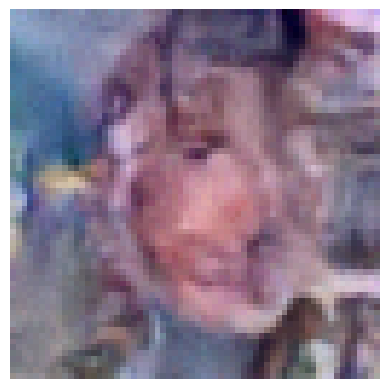

In [12]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    dataset = CelebAText2ImageDataset(
        img_dir="Celeb\img_align_celeba\img_align_celeba",
        attr_path="Celeb\list_attr_celeba.csv",
        split_path="Celeb\list_eval_partition.csv",
        split="train",
        transform=transform
    )

    dataset = torch.utils.data.Subset(dataset, range(30000))

    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    model = EnhancedUNet().to(device)
    embedder = CLIPTextEmbedder(device)
    diffusion = Diffusion(timesteps=200)

    train(model, embedder, diffusion, dataloader, device)

    prompt = "smiling woman with brown hair and eyeglasses"
    generated = generate_with_cfg(model, embedder, diffusion, prompt, device)
    show_image(generated)